## Basic config, package loading

In [1]:
### Set CUDA device
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [2]:
from torch import Tensor
import sys
from omegaconf import OmegaConf
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Callable, Tuple
from copy import deepcopy
import wandb

sys.path.append('../')
from data_utils import get_eval_data
from model.unet import get_unet

## Model selection

In [3]:
cfg = OmegaConf.load('../configs/conf.yaml')
OmegaConf.update(cfg, 'run.iteration', 3)

LOG = False
DATA_KEY = 'prostate'
OmegaConf.update(cfg, 'run.data_key', DATA_KEY)

unet_name = 'monai-64-4-4'
args = unet_name.split('-')
cfg.unet[DATA_KEY].pre = unet_name
cfg.unet[DATA_KEY].arch = args[0]
cfg.unet[DATA_KEY].n_filters_init = None if unet_name == 'swinunetr' else int(args[1])
if args[0] == 'monai':
    cfg.unet[DATA_KEY].depth = int(args[2])
    cfg.unet[DATA_KEY].num_res_units = int(args[3])

if LOG:
    wandb.init(
        project=cfg.wandb.project,
        config={
            "learning_rate": cfg.unet[DATA_KEY].training.lr,
            "architecture": unet_name,
            "dataset": DATA_KEY
        }
    )

from data_utils import get_pmri_data_loaders
from dataset import MultisiteMRIProstateDataset
from trainer.unet_trainer import get_unet_trainer
import torch

unet, _ = get_unet(cfg, update_cfg_with_swivels=False, return_state_dict=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unet.to(device);
# train_loader, val_loader = get_pmri_data_loaders(cfg=cfg)
# pmri_trainer = get_unet_trainer(cfg=cfg, train_loader=train_loader, val_loader=val_loader, model=unet)
# try:
#     pmri_trainer.fit()
# finally:
#     wandb.finish()


/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from pathlib import Path
pmri_data_path = Path('/data/Data/PMRI').resolve()
data_train = MultisiteMRIProstateDataset(pmri_data_path, 'siemens', 'train', load_only_present=True)
data_valid = MultisiteMRIProstateDataset(pmri_data_path, 'siemens', 'valid', load_only_present=True)
len(data_train), len(data_valid)

(986, 236)

In [5]:
train_loader, val_loader = get_pmri_data_loaders(cfg=cfg)

Loading training PMRI dataset...
Loading validation PMRI dataset...


In [6]:
batch = next(train_loader)
batch.keys(), batch['target'].shape

(dict_keys(['data', 'data_orig', 'target_orig', 'target']),
 torch.Size([32, 1, 256, 256]))

[25 14 19 25 26]


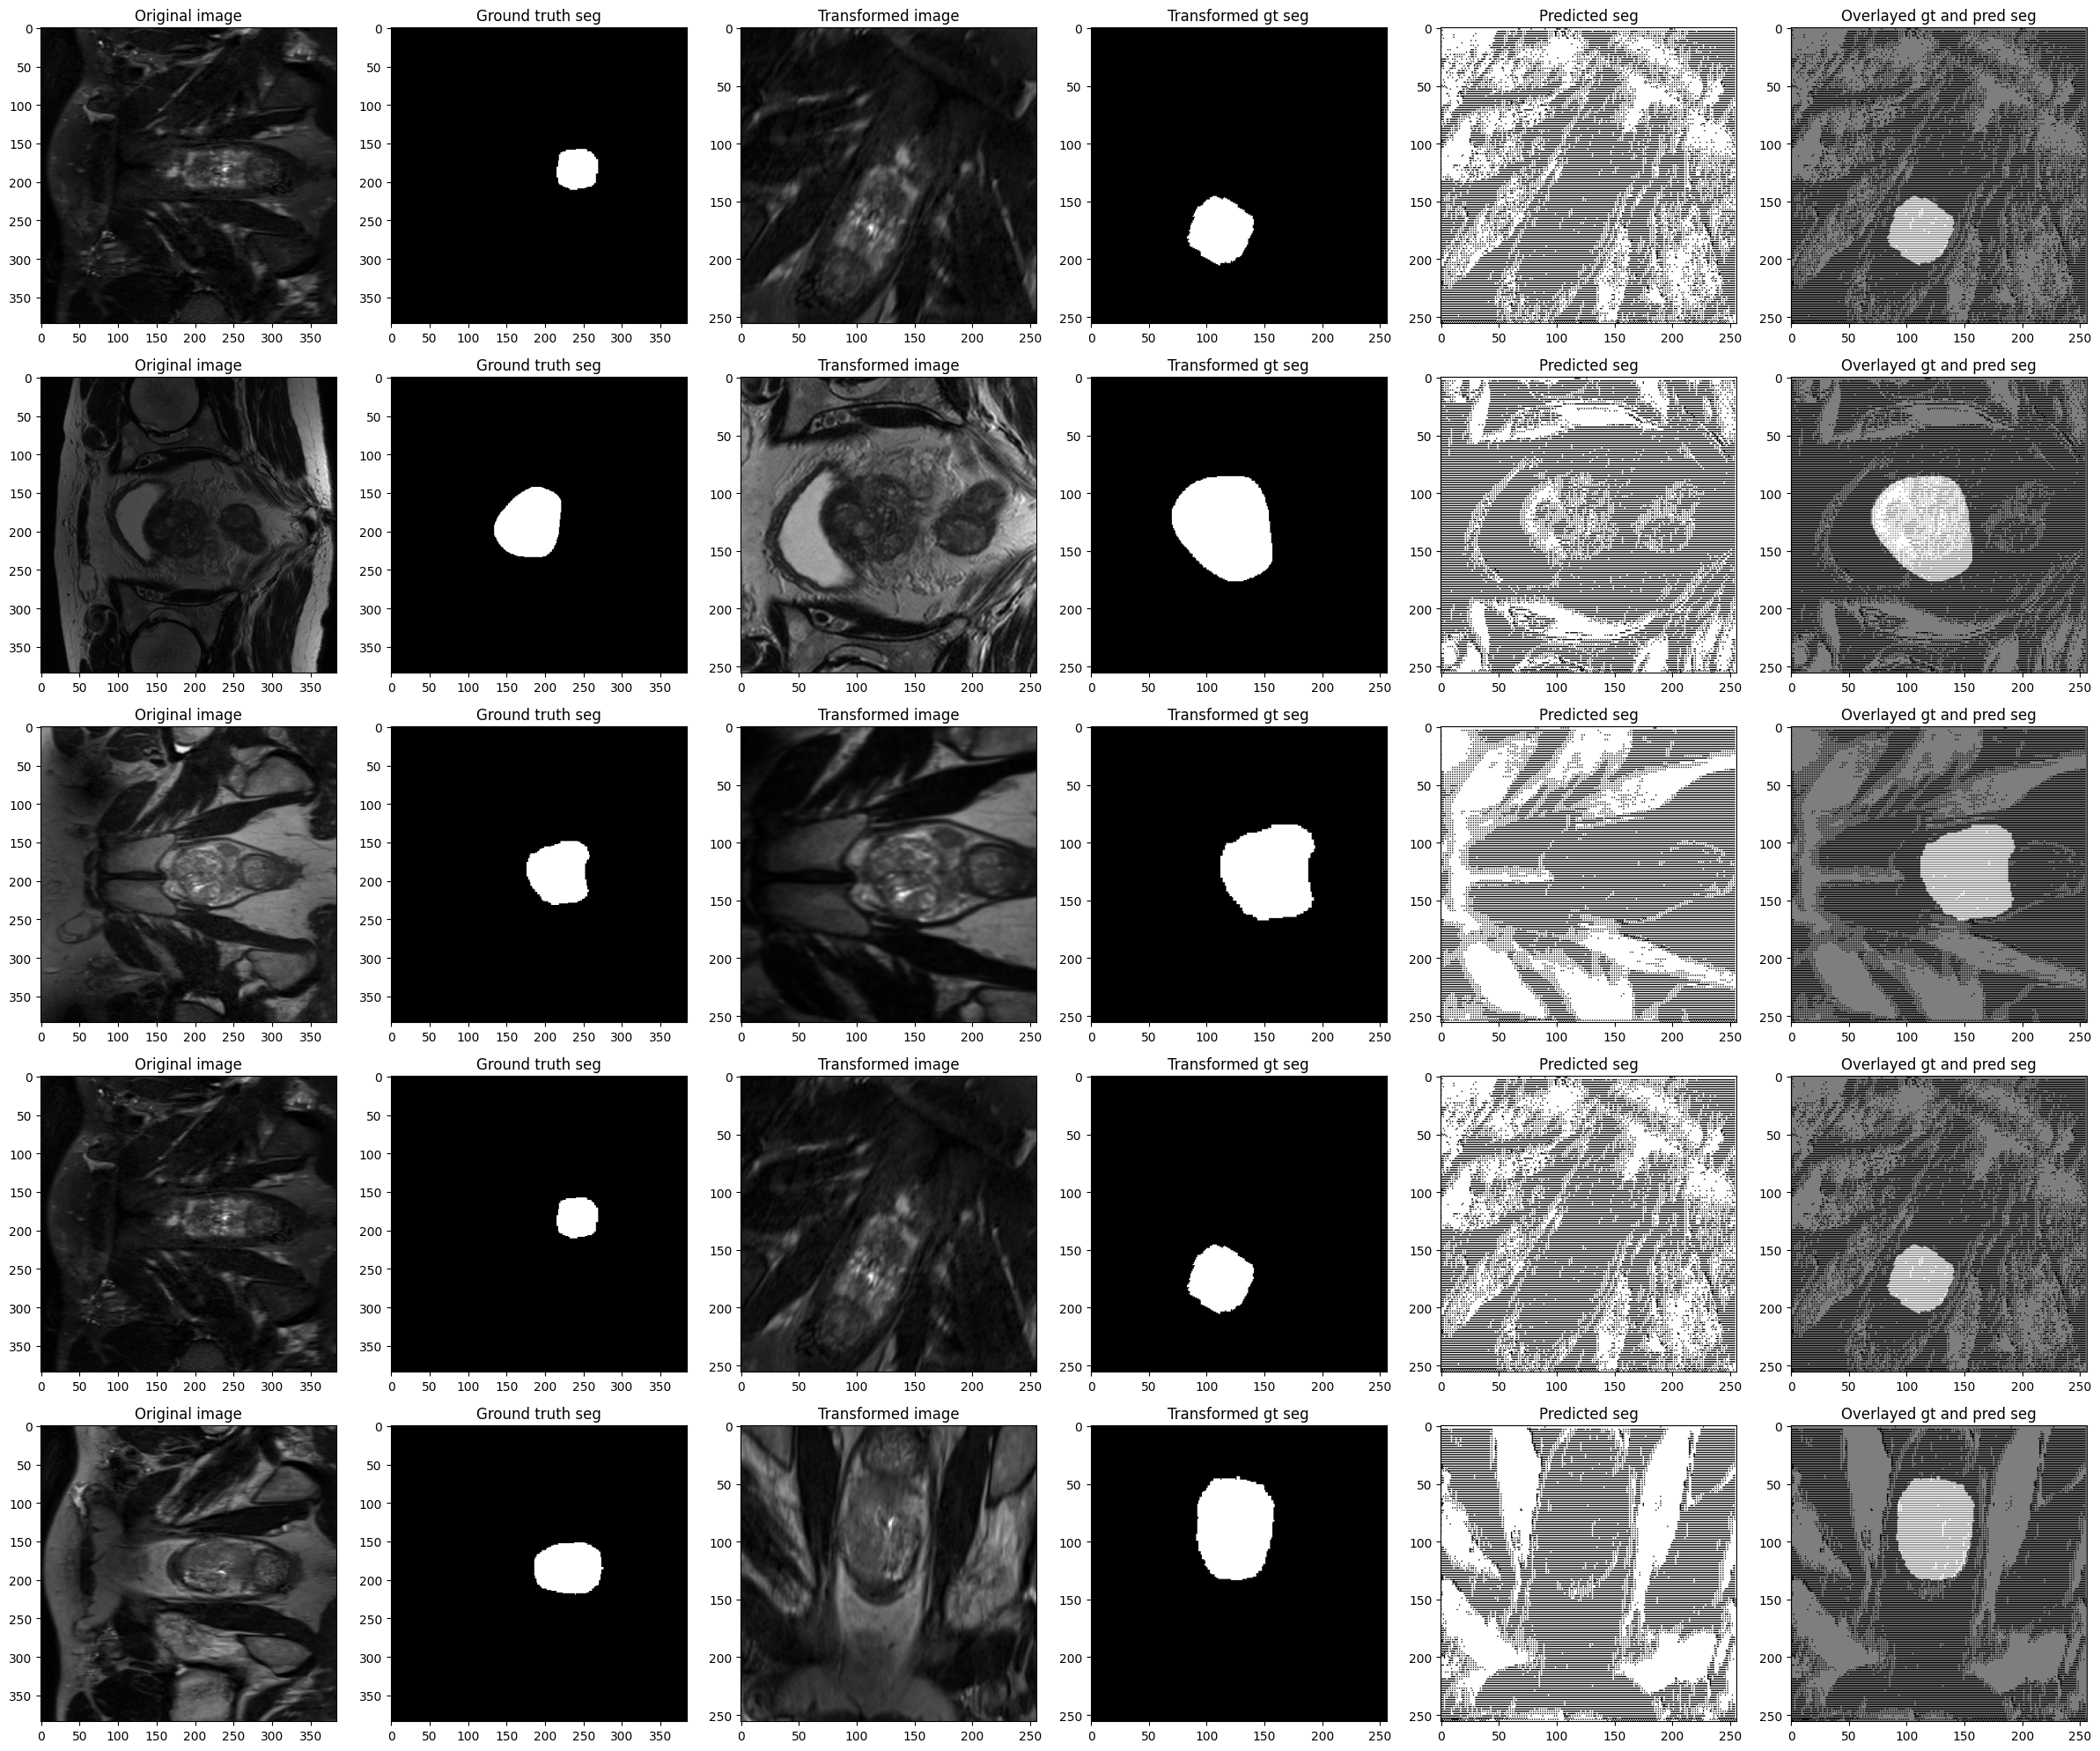

In [7]:
import numpy as np
import torch

num_imgs = 5
indices = np.random.randint(0, batch['target'].shape[0], num_imgs)
print(indices)
fig, axs  = plt.subplots(num_imgs, 6, figsize=(24,20))
images_og = batch['data_orig'][indices]
labels_og = batch['target_orig'][indices]
images_mod = batch['data'][indices] #.permute(3, 0, 1, 2)
labels_mod = batch['target'][indices] #.permute(3, 0, 1, 2)
with torch.no_grad():
    unet.eval()
    pred = unet(images_mod.float().cuda())
    pred = torch.argmax(pred, dim = 1).detach().cpu()

for i in range(num_imgs):
    axs[i][0].set_title('Original image')
    axs[i][0].imshow(images_og[i].squeeze(), cmap='gray')
    axs[i][1].set_title('Ground truth seg')
    axs[i][1].imshow(labels_og[i].squeeze(), cmap='gray')
    axs[i][2].set_title('Transformed image')
    axs[i][2].imshow(images_mod[i].squeeze(), cmap='gray')
    axs[i][3].set_title('Transformed gt seg')
    axs[i][3].imshow(labels_mod[i].squeeze(), cmap='gray')
    axs[i][4].set_title('Predicted seg')
    axs[i][4].imshow(pred[i], cmap='gray')
    axs[i][5].set_title('Overlayed gt and pred seg')
    axs[i][5].imshow(labels_mod[i].squeeze(), cmap='gray')
    axs[i][5].imshow(pred[i], cmap='gray', alpha=0.5)

plt.tight_layout()

## Train model

## Everything Data

In [ ]:
# Set debug mode for only a small fraction of the datasets. Speeds up this cell by alot
cfg.debug = True


# Wether and how you want to subset in case of Brain data. WARNING:
# After subsetting the eval below will not work with surface
# Dice anymore, because volumes are fragmented. 
APPLY_SUBSETTING = True
OmegaConf.update(cfg, 'eval.data.subset.apply', APPLY_SUBSETTING)
subset_params = {
    'n_cases': 256,  # selects at most so many cases
    'fraction': 0.1, # selects from the 10% worst cases w.r.t to a model
}
OmegaConf.update(
    cfg, 
    'eval.data.subset.params', 
    OmegaConf.create(subset_params)
)

if cfg.eval.data.subset.apply:
    subset_dict = OmegaConf.to_container(
        cfg.eval.data.subset.params, 
        resolve=True, 
        throw_on_missing=True
    )
    subset_dict['unet'] = unet
else:
    subset_dict = None

### select the datasets within the domain
# get training data
cfg.eval.data.training = True
# get validation data
cfg.eval.data.validation = True
# get testing data
# Options for Brain are any subset of [1, 2, 3, 4, 5] or 'all' 
# Options for Heart are any subset of ['A', 'B', 'C', 'D'] or 'all'
cfg.eval.data.testing = ['A']


data = get_eval_data(
    train_set=cfg.eval.data.training,
    val_set=cfg.eval.data.validation,
    test_sets=cfg.eval.data.testing,    
    cfg=cfg,
    subset_dict=subset_dict
)

print(f'\nAvailable datasets are: {list(data.keys())}')

In [ ]:
## Sanity Check if config is as expected
print(OmegaConf.to_yaml(cfg))

## General Eval Pipeline

In [4]:
from losses import (
    DiceScoreCalgary, 
    DiceScoreMMS,
    DiceScorePMRI
)

data = get_eval_data(
    train_set=False,
    val_set=True,
    cfg=cfg
)

Loading validation PMRI dataset...


In [5]:

#####################################################
### From eval.unet_test. Modify to fit your needs ###
#####################################################

from typing import Dict
from omegaconf import OmegaConf
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from utils import  epoch_average

def get_df_from_dict(
    cfg: OmegaConf,
    metrics: Dict
):
    # convert dict into seaborn-friendly pandas format
    df = pd.DataFrame.from_dict(metrics).T
    df['Domain'] = df.index
    df.reset_index(drop=True, inplace=True)
    df = pd.melt(
        df, 
        id_vars=['Domain'],
        value_vars=df.columns.drop('Domain')
    )
    # add additional identifiers from config
    df['Iteration'] = cfg.run.iteration
    df['Model'] = cfg.unet[cfg.run.data_key].pre
    df['Data'] = cfg.run.data_key

    return df


def eval_set(
    cfg: OmegaConf,
    model: nn.Module,
    dataset: Dataset
) -> Dict:
    if cfg.run.data_key == 'brain':
        dataset.volume_wise = True
        dataloader = DataLoader(
            dataset,
            batch_size=32,
            shuffle=False,
            drop_last=False
        )
        eval_metrics = {
            'Volumetric Dice': DiceScoreCalgary(),
            # Surface Dice is not defined for fragmented volumes, which we get
            # by subsetting above. The original eval function in
            # eval.unet_test does support surface Dice but not subsetting.
            # 'Surface Dice': SurfaceDiceCalgary() 
        }
        metrics = eval_brain_set(
            model=model, 
            dataloader=dataloader, 
            eval_metrics=eval_metrics
        )

    elif cfg.run.data_key == 'heart':
        dataloader = DataLoader(dataset, 
            batch_size=32, 
            shuffle=False, 
            drop_last=False
        )
        eval_metrics = {
            "Volumetric Dice": DiceScoreMMS()
        }
        metrics = eval_heart_set(
            model=model, 
            dataloader=dataloader, 
            eval_metrics=eval_metrics
        )

    elif cfg.run.data_key == 'prostate':
        dataloader = DataLoader(dataset, batch_size=32,
                                shuffle=False, drop_last=False)
        eval_metrics = {
            "Dice Score": DiceScorePMRI()
        }
        metrics = eval_pmri_set(
            model=model,
            dataloader=dataloader,
            eval_metrics=eval_metrics
        )
    
    else:
        raise ValueError(
            f'Invalid data key. No dataset named {cfg.run.data_key}'
        )

    return metrics

@torch.no_grad()
def eval_brain_set(
    model: nn.Module, 
    dataloader: DataLoader, 
    eval_metrics: Dict
) -> Dict:
    model.eval()
    batch_sizes = []
    epoch_metrics = {key: [] for key in eval_metrics.keys()}
    for batch in dataloader:
        input_ = batch['input']
        target = batch['target']
        batch_sizes.append(input_.shape[0])
        net_out = model(input_.cuda()).detach().cpu()
        for key, metric in eval_metrics.items():
            epoch_metrics[key].append(metric(net_out,target).detach().mean().cpu())

    for key, epoch_scores in epoch_metrics.items():
        epoch_metrics[key] = epoch_average(epoch_scores, batch_sizes)

    return epoch_metrics

@torch.no_grad()
def eval_pmri_set(model, dataloader, eval_metrics):
    model.eval()
    epoch_metrics = {key: [] for key in eval_metrics.keys()}
    batch_sizes = []
    for batch in dataloader:
        input_ = batch['input'].float()
        target = batch['target'].long()
        batch_sizes.append(input_.shape[0])
        out = model(input_.cuda()).detach().cpu()
        for key, metric in eval_metrics.items():
            epoch_metrics[key].append(metric(out, target).detach().mean().cpu())

    for key, epoch_scores in epoch_metrics.items():
        epoch_metrics[key] = epoch_average(epoch_scores, batch_sizes)
    
    return epoch_metrics

@torch.no_grad()
def eval_heart_set(
    model: nn.Module, 
    dataloader: DataLoader, 
    eval_metrics: Dict
) -> Dict:
    model.eval()
    epoch_metrics = {key: [] for key in eval_metrics.keys()}
    # saves batch sizes for each batch for averaging
    batch_sizes = []
    for batch in dataloader:
        input_ = batch['input']
        target = batch['target'].cuda()
        # convert -1 labels to background
        target[target == -1] = 0
        # convert to one-hot encoding
        target = F.one_hot(
            target.long(), 
            num_classes=4
        ).squeeze(1).permute(0,3,1,2)
        # get model output
        net_out = model(input_.cuda())
        
        batch_sizes.append(input_.shape[0])
        for key, metric in eval_metrics.items():
            epoch_metrics[key].append(
                metric(net_out, target).detach().mean().cpu()
            )
            
    for key, epoch_scores in epoch_metrics.items():
        epoch_metrics[key] = epoch_average(epoch_scores, batch_sizes)
        
    return epoch_metrics

torch.Size([32, 384, 384])
torch.Size([32, 1, 384, 384])
torch.Size([32, 384, 384])
torch.Size([32, 1, 384, 384])
torch.Size([32, 384, 384])
torch.Size([32, 1, 384, 384])
torch.Size([32, 384, 384])
torch.Size([32, 1, 384, 384])
torch.Size([32, 384, 384])
torch.Size([32, 1, 384, 384])
torch.Size([32, 384, 384])
torch.Size([32, 1, 384, 384])
torch.Size([32, 384, 384])
torch.Size([32, 1, 384, 384])
torch.Size([12, 384, 384])
torch.Size([12, 1, 384, 384])


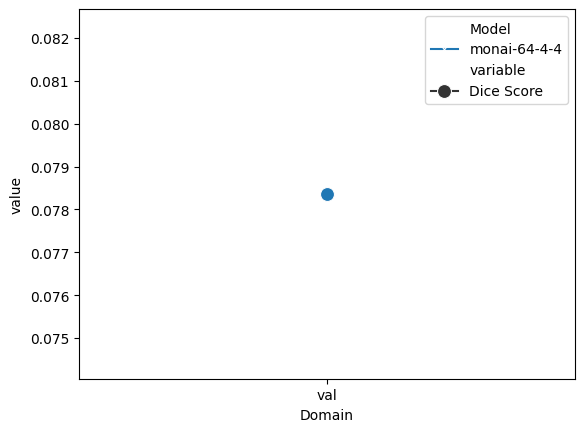

In [6]:
metrics = {}

for key in data.keys():
    metrics[key] = eval_set(
        cfg=cfg,
        model=unet,
        dataset=data[key]
    )

df = get_df_from_dict(cfg, metrics)

sns.lineplot(
    data=df, 
    x='Domain', 
    y='value', 
    hue='Model',
    style='variable',
    markers=True, 
    dashes=False, 
    markersize=10, 
    marker='x'
)
plt.show()

## Image selection and analysis

In [ ]:
# select single image
print(f'\nAvailable datasets are:')
for key in data:
    print(f'  {key}: {len(data[key])} images')


domain = 'val'
idx    = 20
image, seg_mask, voxel_spacing = data[domain][idx].values()

In [ ]:
# segment image
with torch.no_grad():
    net_out = unet(image.unsqueeze(0).cuda()).detach().cpu()
    if DATA_KEY == 'brain':
        prediction = (net_out[0] > 0.5) * 1
    elif DATA_KEY == 'heart':
        prediction = net_out.argmax(1)
    error_map = (seg_mask - prediction).abs()


# plot results
def plot_side_by_side(
    images: List[Tensor], 
    titles: List[str] = None, 
    cmap: str = 'gray'
):
    n = len(images)
    fig, axes = plt.subplots(1, n, figsize=(n * 5, 5))
    
    if n == 1:  # If only one image, wrap axes in a list to make iterable
        axes = [axes]
    
    for i, ax in enumerate(axes):
        ax.imshow(images[i], cmap=cmap)
        ax.axis('off')
        if titles:
            ax.set_title(titles[i], fontsize=15)
        
    plt.tight_layout()
    return fig


fig = plot_side_by_side(
    images = [
        image[0], 
        seg_mask[0], 
        prediction[0], 
        error_map[0],
    ], 
    titles = [
        'Input', 
        'Ground Truth', 
        'Prediction',
        'Error Map',
    ]  # comment to hide titles
)

## Adapter Example

In [ ]:
# A simple Adapter to store some inputs

class DummyAdapter(nn.Module):
    """Dummy Adapter to store input means for a given layer per batch.

    Attach this adapter via hooks (forward, preforward) to a layer in a 
    model by name of that layer. After each forward pass, the input means
    are stored in the attribute `input_means` of this adapter.

    Args:
        swivel (str): Name of the layer in the model to attach to.
        device (str, optional): Device to store the input means on. Defaults to 'cuda:0'.
    """
    def __init__(
        self,
        swivel: str,
        device: str  = 'cuda:0'
    ):
        super().__init__()
        # init args
        self.swivel = swivel
        self.device = device
        self.to(device)


    ### private methods ###
        
    def _aggregate(
        self, 
        x: Tensor
    ) -> Tensor:
        
        return x.mean(dim=(1,2,3))
    

    ### public methods ###

    def forward(
        self, 
        x: Tensor
    ) -> Tensor:
        self.input_means = self._aggregate(x).detach()

        return x
    

# A wrapper for this kind of adapter and the model itself
    
class DummyWrapper(nn.Module):
    """Wrapper for a model and a list of adapters.

    Each adapter is attached to a layer in the model via hooks. The layers
    are defined in the adapters themselves. 
    """
    def __init__(
        self,
        model: nn.Module,
        adapters: nn.ModuleList,
        copy: bool = True,
    ):
        super().__init__()
        self.model = deepcopy(model) if copy else model
        self.adapters = adapters
        self.adapter_handles = {}
        self.model.eval()

        self.input_means = {}


    def hook_adapters(
        self,
    ) -> None:
        # iterate over all adapters. You can use multiple simultaneously
        for adapter in self.adapters:
            # get the layer name of the layer we want to attach to
            swivel = adapter.swivel
            # get the actual layer from the model
            layer  = self.model.get_submodule(swivel)
            # get the hook function for this layer/adapter
            hook = self._get_hook(adapter, swivel)
            # attach the hook to the layer and save handle to remove hook 
            # if needed 
            self.adapter_handles[
                swivel
            ] = layer.register_forward_pre_hook(hook)


    def _get_hook(
        self,
        adapter: nn.Module,
        swivel: str
    ) -> Callable:
        # registering hooks requires a function that takes the module and the input,
        # nothing more. To access the adapter anyways, we create the hook in a 
        # scope where the adapter is accessible, i.e. in another function.
        def hook_fn(
            module: nn.Module, 
            x: Tuple[Tensor]
        ) -> Tensor:
            # hook signature given by pytorch:
            # hook(module, input) -> None or modified input

            # pass through the adapter
            out = adapter(x[0])
            # save the results from this hook in a dict by layer name
            self.input_means[swivel] = adapter.input_means.cpu()

            return out
        
        return hook_fn


    def forward(
        self, 
        x: Tensor
    ) -> Tensor:
        # hijack the forward pass of your actual model
        return self.model(x)

In [ ]:
#  run an example
n = 3

# select some layers at random
layer_names = [layer[0] for layer in unet.named_modules() if 'conv' in layer[0]]
selection = [
    layer_names[i] for i in torch.randperm(len(layer_names))[:n]
]

# create adapters for these layers and wrap them in a wrapper
adapters = nn.ModuleList(
    [DummyAdapter(swivel) for swivel in selection]
)

wrapper = DummyWrapper(
    model=unet, 
    adapters=adapters
)
wrapper.hook_adapters()

# do a forward pass and inspect results
input_batch = data[key][:5]['input']
_ = wrapper(input_batch.cuda())

print('Mean for batch / layer:')
for layer in selection:
    print(f'{wrapper.input_means[layer].tolist()} {layer}')
